In [1]:
import xarray as xr
import numpy as np

import shapely
import geopandas as gpd
import salem

import cartopy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
nc = xr.open_dataset('/mnt/efs/data/oaflux_turbu_sh.nc')
nc['lhtfl'] = xr.open_dataset('/mnt/efs/data/oaflux_turbu_lh.nc').lhtfl

In [3]:
nc_l = nc.sel(lon=slice(180,360))
nc_l['lon'] = nc_l['lon'] - 360
nc_r = nc.sel(lon=slice(0,180))
ds = xr.concat([nc_l,nc_r],dim='lon')
del nc_l,nc_r

In [4]:
nc = xr.open_dataset('/mnt/efs/data/area1x1.nc').rename({'AREA':'area','LATITUDE':'lat','LONGITUDE':'lon'})
ds['area'] = nc.area
ds.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

In [5]:
tstart = '1990-01-01'
tend = '2018-12-31'
south,north,west,east = 30,90,-90,20

In [6]:
shtfl = ds.shtfl.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))
lhtfl = ds.lhtfl.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

htfl = shtfl+lhtfl

In [7]:
boundary_coords = np.loadtxt('/mnt/efs/data/spg_boundary.txt')

In [8]:
# Replace each pair of points by 10 points for projected map
geometry = []
segments = zip(boundary_coords[:-1,0], boundary_coords[:-1,1],
               boundary_coords[1:,0], boundary_coords[1:,1])

for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
    for length in np.linspace(0,1,11):
        geometry.append( line.interpolate(length, normalized=True) )
        
gdf_patch = gpd.GeoDataFrame([], geometry=geometry)

# Convert Points to Polygon
gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])

gdf_patch['shape_id'] = 0
gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()

gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')

# Salem uses this attribute:
gdf_patch.crs = {'init': 'epsg:4326'}

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [8]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]

In [10]:
gdf_patch = get_gdf_patch(coords_spna)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
htfl_djf = htfl[(htfl.time.dt.month==1)|(htfl.time.dt.month==2)|(htfl.time.dt.month==12)].mean('time',skipna=False)

/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


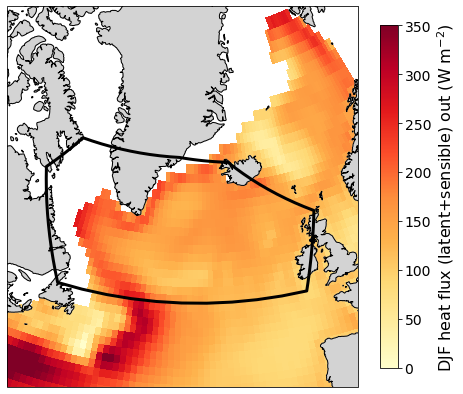

In [12]:
fig = plt.figure(figsize=(8,7))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-30.0,central_latitude=40.0))
ax.set_extent([-60, -5, 37, 80], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax.coastlines(resolution='50m',linewidth=1.0,zorder=2)

p = ax.pcolormesh(htfl_djf.lon-0.5, htfl_djf.lat-0.5,np.ma.masked_invalid(htfl_djf),
                  cmap='YlOrRd', vmin=0, vmax=350, transform=cartopy.crs.PlateCarree())

ax.add_geometries([gdf_patch['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', 
                  linewidth=3, linestyle='-')

cb = fig.colorbar(p,ticks=np.arange(0,400,50), orientation='vertical', shrink=0.9)
cb.set_label(r'DJF heat flux (latent+sensible) out (W m$^{-2}$)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

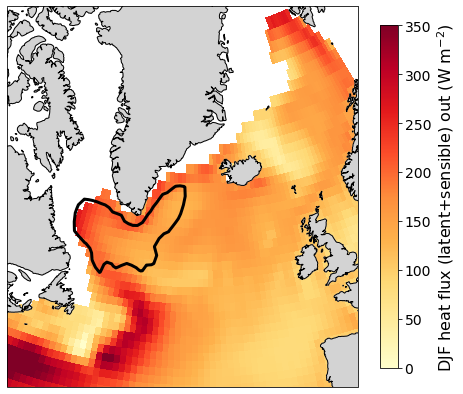

In [13]:
htfl_patch = htfl.salem.roi(shape=gdf_patch.loc[[0]])
#htfl_patch = htfl.salem.roi(shape=gdf_patch.loc[[0]]).sel(lon=slice(-70,-50))

area_patch = ((htfl_patch/htfl_patch)*ds.area).sum(dim=['lat','lon'])
htfl_patch_mean = (htfl_patch*ds.area/area_patch).sum(dim=['lat','lon'])

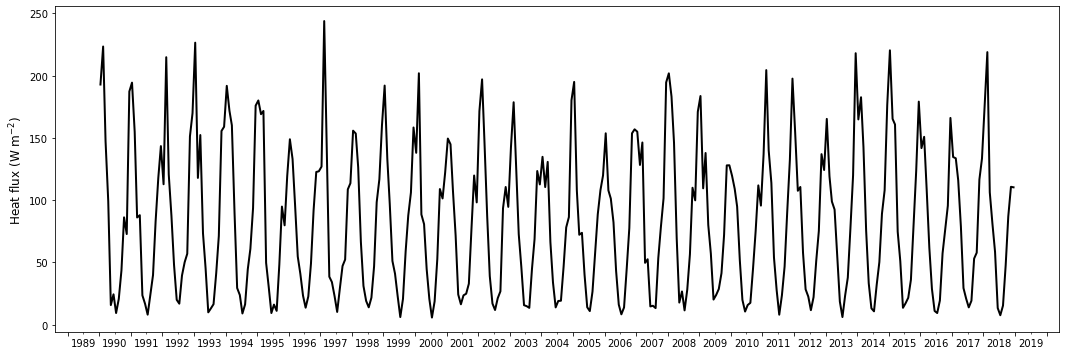

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(htfl_patch_mean.time, htfl_patch_mean, color='k', lw=2, linestyle='-')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.YearLocator(month=7))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
ax.set_ylabel('Heat flux (W m$^{-2}$)',fontsize=12)
plt.show()

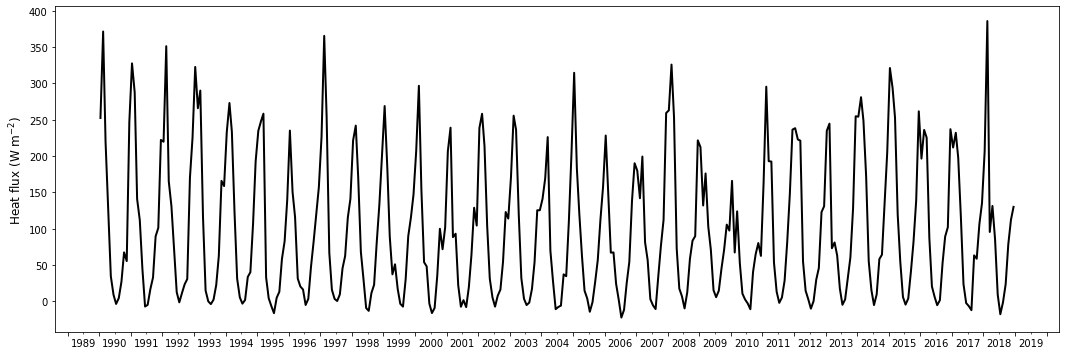

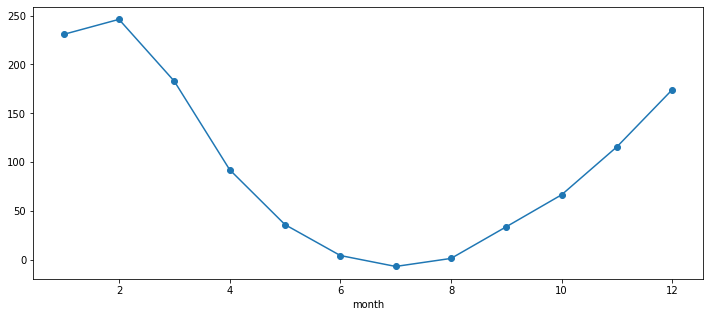

In [13]:
htfl_patch_mean.groupby('time.month').mean('time').plot(marker='o',figsize=(12,5))

In [15]:
df = htfl_patch_mean.to_dataframe(name='htfl')

In [16]:
df.to_csv('/mnt/efs/data/oaflux_htfl_spna.csv', index=True)